# Unified Model with Integrated Bot

James Yu, 11 August 2022

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv
np.set_printoptions(suppress=True) # disable scientific notation for readability

In [2]:
def infinite_solution(A_n, A_c, delta, c, x_0, z, b = np.identity(3)):
    n = len(x_0)
    eps = np.finfo(np.float64).eps
    I = np.identity(n)
    O = np.zeros((n, n))
    
    Q = np.block([
        [I, O], 
        [O, O]
    ])
    A = np.block([
        [A_n, A_c], 
        [O, I]
    ])
    B = np.block([
        [b], # identity matrix by default 
        [O]
    ])
    K_t = Q
    K_sequence = [K_t]
    
    while True: # generate solution matrices; note I divide delta into the inverse term for simplification
        K_t_new = Q + delta * A.T @ (K_t - K_t @ B @ inv(B.T @ K_t @ B + c * I / delta) @ B.T @ K_t) @ A
        K_sequence.insert(0, K_t_new)
        if np.allclose(K_t, K_t_new, rtol = eps, atol = eps): break
        K_t = K_t_new

    chi_var = np.block([
        [x_0], 
        [z]
    ])
    chi_ts = [chi_var]
    r_ts = []
    K_ss = K_sequence[0]
    L_ss = -inv(B.T @ K_ss @ B + c * I / delta) @ B.T @ K_ss @ A
    
    payoff = 0
    stage_payoffs = []
    discounted_stage_payoffs = []
    cumulative_payoffs = []
    
    i = 0
    while True:
        r_t = L_ss @ chi_var
        r_ts.append(r_t)
        p = -(chi_var.T @ Q @ chi_var + c * r_t.T @ r_t).item()
        payoff += delta**i * p
        stage_payoffs.append(p)
        discounted_stage_payoffs.append(delta**i * p)
        cumulative_payoffs.append(payoff)
        chi_var_new = A @ chi_var + B @ r_t
        chi_ts.append(chi_var_new)
        if np.allclose(chi_var, chi_var_new, rtol = eps, atol = eps): break
        chi_var = chi_var_new
        i += 1
        
    return chi_ts, r_ts, stage_payoffs, discounted_stage_payoffs, cumulative_payoffs, K_ss, L_ss

# A generic test:

In [3]:
A_1_n = 0.99 * np.array([
    [0.3, 0.4, 0.3],
    [0.6, 0.2, 0.2],
    [0.5, 0.1, 0.4]
])
A_1_c = np.diag([0.01, 0.01, 0.01])

delta = 0.9
c = 1.0
x_0 = np.array([[10.0, 5.0, -20.0]], ndmin = 2).T
z = np.array([[5.0, 5.0, 5.0]], ndmin = 2).T

In [4]:
chi_ts, r_ts, stage_payoffs, discounted_stage_payoffs, cumulative_payoffs, K_ss, L_ss = infinite_solution(A_1_n, A_1_c, delta, c, x_0, z)

In [5]:
print(K_ss)

[[1.38616486 0.17105178 0.23321578 0.00371302 0.0044536  0.00413393]
 [0.17105178 1.11998571 0.11887399 0.00315167 0.00201313 0.00154197]
 [0.23321578 0.11887399 1.16516367 0.00293632 0.00209553 0.00321817]
 [0.00371302 0.00315167 0.00293632 0.00070065 0.00022898 0.00020687]
 [0.0044536  0.00201313 0.00209553 0.00022898 0.00055207 0.00005221]
 [0.00413393 0.00154197 0.00321817 0.00020687 0.00005221 0.0006539 ]]


In [6]:
print(L_ss)

[[-0.20416138 -0.22807784 -0.18698905 -0.00678598 -0.00198875 -0.00195085]
 [-0.316895   -0.11369141 -0.11730197 -0.00157713 -0.00571962 -0.00073902]
 [-0.2773602  -0.07228275 -0.21818719 -0.0015369  -0.00094037 -0.00629405]]


In [7]:
chi_ts[-1] # terminal opinions

array([[-0.00103162],
       [ 0.01107937],
       [ 0.00755896],
       [ 5.        ],
       [ 5.        ],
       [ 5.        ]])

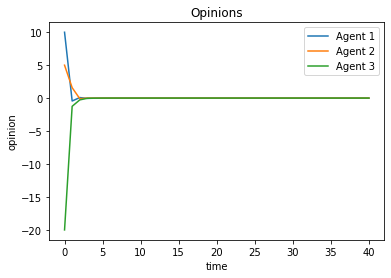

In [8]:
for r in range(3):
    plt.plot(range(len(chi_ts)), [chi_t[r] for chi_t in chi_ts], label = f"Agent {r+1}")
plt.title("Opinions")
plt.xlabel("time")
plt.ylabel("opinion")
plt.legend()
plt.show()

In [9]:
r_ts[-1] # terminal message

array([[-0.05735767],
       [-0.04199823],
       [-0.04602059]])

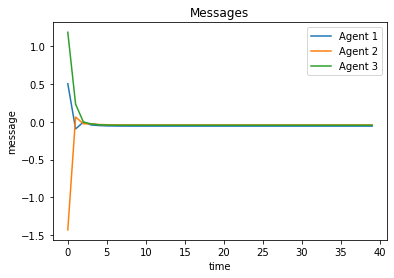

In [10]:
for r in range(3):
    plt.plot(range(len(r_ts)), [r_t[r] for r_t in r_ts], label = f"Agent {r+1}")
plt.title("Messages")
plt.xlabel("time")
plt.ylabel("message")
plt.legend()
plt.show()

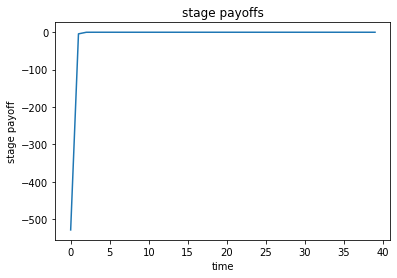

In [11]:
plt.plot(range(len(stage_payoffs)), stage_payoffs)
plt.title("stage payoffs")
plt.xlabel("time")
plt.ylabel("stage payoff")
plt.show()

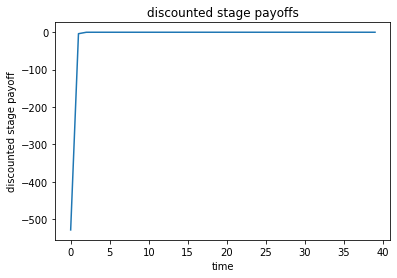

In [12]:
plt.plot(range(len(discounted_stage_payoffs)), discounted_stage_payoffs)
plt.title("discounted stage payoffs")
plt.xlabel("time")
plt.ylabel("discounted stage payoff")
plt.show()

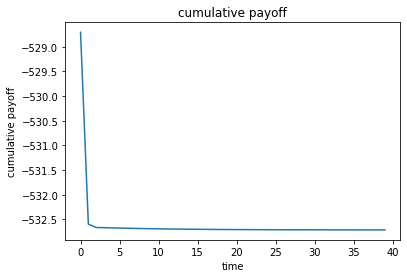

In [13]:
plt.plot(range(len(cumulative_payoffs)), cumulative_payoffs)
plt.title("cumulative payoff")
plt.xlabel("time")
plt.ylabel("cumulative payoff")
plt.show()

# Comparative Statics

Each test is an independent change of the defaults; no changes are reused in subsequent tests.

In [14]:
chi_ts[-1] # terminal opinions with above settings, benchmark for below tests

array([[-0.00103162],
       [ 0.01107937],
       [ 0.00755896],
       [ 5.        ],
       [ 5.        ],
       [ 5.        ]])

## Decrease $\delta$:

In [15]:
delta_test = 0.1
chi_ts_1, r_ts_1, _, _, _, K_ss_1, L_ss_1 = infinite_solution(A_1_n, A_1_c, delta_test, c, x_0, z)
chi_ts_1[-1] # terminal opinions

array([[0.40973702],
       [0.41199308],
       [0.41127104],
       [5.        ],
       [5.        ],
       [5.        ]])

## Decrease $c$:

In [16]:
c_test = 0.001
chi_ts_2, r_ts_2, _, _, _, K_ss_2, L_ss_2 = infinite_solution(A_1_n, A_1_c, delta, c_test, x_0, z)
chi_ts_2[-1] # terminal opinions

array([[-0.00001371],
       [ 0.00002088],
       [ 0.000011  ],
       [ 5.        ],
       [ 5.        ],
       [ 5.        ]])

## Increase $c$:

In [17]:
c_test = 100.0
chi_ts_3, r_ts_3, _, _, _, K_ss_3, L_ss_3 = infinite_solution(A_1_n, A_1_c, delta, c_test, x_0, z)
chi_ts_3[-1] # terminal opinions

array([[0.50871404],
       [0.52536063],
       [0.52041665],
       [5.        ],
       [5.        ],
       [5.        ]])

## Increase bot agenda magnitude:

In [18]:
z_test = np.array([[-100.0, -100.0, -100.0]], ndmin = 2).T
chi_ts_4, r_ts_4, _, _, _, K_ss_4, L_ss_4 = infinite_solution(A_1_n, A_1_c, delta, c, x_0, z_test)
chi_ts_4[-1] # terminal opinions

array([[   0.02063247],
       [  -0.22158748],
       [  -0.15117917],
       [-100.        ],
       [-100.        ],
       [-100.        ]])

## Decrease bot agenda magnitude:

In [19]:
z_test = np.array([[0.001, 0.001, 0.001]], ndmin = 2).T
chi_ts_5, r_ts_5, _, _, _, K_ss_5, L_ss_5 = infinite_solution(A_1_n, A_1_c, delta, c, x_0, z_test)
chi_ts_5[-1] # terminal opinions

array([[-0.00000021],
       [ 0.00000222],
       [ 0.00000151],
       [ 0.001     ],
       [ 0.001     ],
       [ 0.001     ]])

## Increase initial opinion magnitudes:

In [20]:
x_0_test = np.array([[10000, 5000, -20000]], ndmin = 2).T
chi_ts_6, r_ts_6, _, _, _, K_ss_6, L_ss_6 = infinite_solution(A_1_n, A_1_c, delta, c, x_0_test, z)
chi_ts_6[-1] # terminal opinions

array([[-0.00103162],
       [ 0.01107937],
       [ 0.00755896],
       [ 5.        ],
       [ 5.        ],
       [ 5.        ]])

## Opinions on same side:

In [21]:
x_0_test = np.array([[100, 50, 200]], ndmin = 2).T
chi_ts_7, r_ts_7, _, _, _, K_ss_7, L_ss_7 = infinite_solution(A_1_n, A_1_c, delta, c, x_0_test, z)
chi_ts_7[-1] # terminal opinions

array([[-0.00103162],
       [ 0.01107937],
       [ 0.00755896],
       [ 5.        ],
       [ 5.        ],
       [ 5.        ]])

## Polar opposite opinions:

In [22]:
x_0_test = np.array([[100, 0, -100]], ndmin = 2).T
chi_ts_8, r_ts_8, _, _, _, K_ss_8, L_ss_8 = infinite_solution(A_1_n, A_1_c, delta, c, x_0_test, z)
chi_ts_8[-1] # terminal opinions

array([[-0.00103162],
       [ 0.01107937],
       [ 0.00755896],
       [ 5.        ],
       [ 5.        ],
       [ 5.        ]])

# Test of the limit formula:

$$x_{ss} = (I - A^n)^{-1} (A^c z + r_{ss})$$

## General Test:

In [23]:
chi_ts[-1]

array([[-0.00103162],
       [ 0.01107937],
       [ 0.00755896],
       [ 5.        ],
       [ 5.        ],
       [ 5.        ]])

In [24]:
I = np.identity(3)
inv(I - A_1_n) @ (A_1_c @ z + r_ts[-1])

array([[-0.00103162],
       [ 0.01107937],
       [ 0.00755896]])

## Decrease $\delta$:

In [25]:
chi_ts_1[-1]

array([[0.40973702],
       [0.41199308],
       [0.41127104],
       [5.        ],
       [5.        ],
       [5.        ]])

In [26]:
inv(I - A_1_n) @ (A_1_c @ z + r_ts_1[-1]) 

array([[0.40973702],
       [0.41199308],
       [0.41127104]])

## Decrease $c$:

In [27]:
chi_ts_2[-1]

array([[-0.00001371],
       [ 0.00002088],
       [ 0.000011  ],
       [ 5.        ],
       [ 5.        ],
       [ 5.        ]])

In [28]:
inv(I - A_1_n) @ (A_1_c @ z + r_ts_2[-1]) 

array([[-0.00001371],
       [ 0.00002088],
       [ 0.000011  ]])

## Increase $c$:

In [29]:
chi_ts_3[-1]

array([[0.50871404],
       [0.52536063],
       [0.52041665],
       [5.        ],
       [5.        ],
       [5.        ]])

In [30]:
inv(I - A_1_n) @ (A_1_c @ z + r_ts_3[-1]) 

array([[0.50871404],
       [0.52536063],
       [0.52041665]])

## Increase bot agenda magnitude:

In [31]:
chi_ts_4[-1]

array([[   0.02063247],
       [  -0.22158748],
       [  -0.15117917],
       [-100.        ],
       [-100.        ],
       [-100.        ]])

In [32]:
z_test = np.array([[-100.0, -100.0, -100.0]], ndmin = 2).T
inv(I - A_1_n) @ (A_1_c @ z_test + r_ts_4[-1]) 

array([[ 0.02063247],
       [-0.22158748],
       [-0.15117917]])

## Decrease bot agenda magnitude:

In [33]:
chi_ts_5[-1]

array([[-0.00000021],
       [ 0.00000222],
       [ 0.00000151],
       [ 0.001     ],
       [ 0.001     ],
       [ 0.001     ]])

In [34]:
z_test = np.array([[0.001, 0.001, 0.001]], ndmin = 2).T
inv(I - A_1_n) @ (A_1_c @ z_test + r_ts_5[-1]) 

array([[-0.00000021],
       [ 0.00000222],
       [ 0.00000151]])

## Increase initial opinion magnitudes:

In [35]:
chi_ts_6[-1]

array([[-0.00103162],
       [ 0.01107937],
       [ 0.00755896],
       [ 5.        ],
       [ 5.        ],
       [ 5.        ]])

In [36]:
inv(I - A_1_n) @ (A_1_c @ z + r_ts_6[-1]) 

array([[-0.00103162],
       [ 0.01107937],
       [ 0.00755896]])

## Opinions on same side:

In [37]:
chi_ts_7[-1]

array([[-0.00103162],
       [ 0.01107937],
       [ 0.00755896],
       [ 5.        ],
       [ 5.        ],
       [ 5.        ]])

In [38]:
inv(I - A_1_n) @ (A_1_c @ z + r_ts_7[-1]) 

array([[-0.00103162],
       [ 0.01107937],
       [ 0.00755896]])

## Polar opposite opinions:

In [39]:
chi_ts_8[-1]

array([[-0.00103162],
       [ 0.01107937],
       [ 0.00755896],
       [ 5.        ],
       [ 5.        ],
       [ 5.        ]])

In [40]:
inv(I - A_1_n) @ (A_1_c @ z + r_ts_8[-1]) 

array([[-0.00103162],
       [ 0.01107937],
       [ 0.00755896]])

# Some questions from before

### 1. $z$ close to zero, $c$ very high:

In [41]:
z_test = np.array([[0.001, 0.001, 0.001]], ndmin = 2).T
c_test = 10000.0
chi_ts_9, r_ts_9, _, _, _, K_ss_9, L_ss_9 = infinite_solution(A_1_n, A_1_c, delta, c_test, x_0, z_test)
chi_ts_9[-1] # terminal opinions

array([[0.0009202 ],
       [0.0009205 ],
       [0.00092041],
       [0.001     ],
       [0.001     ],
       [0.001     ]])

In [42]:
z_test = np.array([[0.001, 0.001, 0.001]], ndmin = 2).T
c_test = 100000000000.0
chi_ts_10, r_ts_10, _, _, _, K_ss_10, L_ss_10 = infinite_solution(A_1_n, A_1_c, delta, c_test, x_0, z_test)
chi_ts_10[-1] # terminal opinions

array([[0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001]])

### 2. Presence of bot vs no presence of bot if bot is a supporter of agent s' agenda:

In [43]:
z_test = np.array([[0, 0, 0]], ndmin = 2).T # bot present but zero
chi_ts_11, r_ts_11, _, _, cumulative_payoffs_11, K_ss_11, L_ss_11 = infinite_solution(A_1_n, A_1_c, delta, c, x_0, z_test)
chi_ts_11[-1] # terminal opinions

array([[-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.]])

In [44]:
cumulative_payoffs_11[-1] # total payoff

-532.7256641192713

In [45]:
len(chi_ts_11) # time to convergence

41

In [46]:
A_1_n_no_bot = np.array([
    [0.3, 0.4, 0.3],
    [0.6, 0.2, 0.2],
    [0.5, 0.1, 0.4]
])

A_1_c_no_bot = np.zeros((3, 3))

chi_ts_12, r_ts_12, _, _, cumulative_payoffs_12, K_ss_12, L_ss_12 = infinite_solution(A_1_n_no_bot, A_1_c_no_bot, delta, c, x_0, z_test)
chi_ts_12[-1] # terminal opinions

array([[-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.]])

In [47]:
cumulative_payoffs_12[-1] # total payoff

-532.8859940230775

In [48]:
len(chi_ts_12) # time to convergence

41

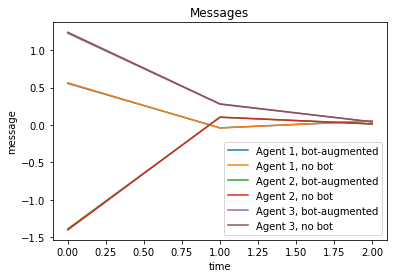

In [49]:
for r in range(3):
    plt.plot(range(3), [r_t[r] for r_t in r_ts_11[:3]], label = f"Agent {r+1}, bot-augmented")
    plt.plot(range(3), [r_t[r] for r_t in r_ts_12[:3]], label = f"Agent {r+1}, no bot")
plt.title("Messages")
plt.xlabel("time")
plt.ylabel("message")
plt.legend()
plt.show()

The difference is extremely subtle, but there is a difference.

In [50]:
r_ts_11[0] # with bot, first period

array([[ 0.55777801],
       [-1.39136764],
       [ 1.22872808]])

In [51]:
r_ts_12[0] # without bot, first period

array([[ 0.56500695],
       [-1.40519451],
       [ 1.24216142]])

With the bot, the messages are less intensive.

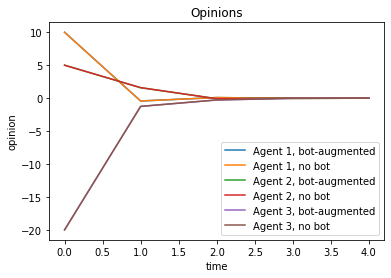

In [52]:
for r in range(3):
    plt.plot(range(5), [chi_t[r] for chi_t in chi_ts_11[:5]], label = f"Agent {r+1}, bot-augmented")
    plt.plot(range(5), [chi_t[r] for chi_t in chi_ts_12[:5]], label = f"Agent {r+1}, no bot")
plt.title("Opinions")
plt.xlabel("time")
plt.ylabel("opinion")
plt.legend()
plt.show()

In [53]:
chi_ts_11[1] # bot-augmented second period

array([[-0.43222199],
       [ 1.57863236],
       [-1.24627192],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

In [54]:
chi_ts_12[1] # no bot second period

array([[-0.43499305],
       [ 1.59480549],
       [-1.25783858],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

Again, very subtle difference but there is a difference.

### 3. Inside vs outside intervention

In [55]:
# no bot, outside intervention is covered by case 12 above
chi_ts_13, r_ts_13, _, _, cumulative_payoffs_13, K_ss_13, L_ss_13 = infinite_solution(A_1_n, A_1_c_no_bot, delta, c, x_0, z_test, b = 0.01 * I)
chi_ts_13[-1] # terminal opinions

array([[-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.]])

In [56]:
cumulative_payoffs_12[-1] # total payoff, outside

-532.8859940230775

In [57]:
cumulative_payoffs_13[-1] # total payoff, inside

-543.843947980425

In [58]:
len(chi_ts_12) # periods, outside

41

In [59]:
len(chi_ts_13) # periods, inside

2830

### 4. choice of target: high info consumption agent or low info consumption agent

In [60]:
A_2_n = np.array([
    [0.195, 0.8, 0.005], # one who listens primarily to someone
    [1/3, 1/3, 1/3], # one who listens to all
    [0.005, 0.005, 0.99] # one who listens to almost nobody
])

In [61]:
# case 1: target specific-follower agent (using the no-bot code from earlier)
b_2 = np.array([
    [1.0, 0.0, 0.0], # target agent 1
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0],
])
chi_ts_14, r_ts_14, _, _, cumulative_payoffs_14, K_ss_14, L_ss_14 = infinite_solution(A_2_n, A_1_c_no_bot, delta, c, x_0, z_test, b = b_2)
chi_ts_14[-1] # terminal opinions

array([[ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.]])

In [62]:
cumulative_payoffs_14[-1]

-4584.144637674463

In [63]:
len(chi_ts_14)

4404

In [64]:
# case 2: target general-follower agent
b_3 = np.array([
    [0.0, 0.0, 0.0], 
    [0.0, 1.0, 0.0], # target agent 2
    [0.0, 0.0, 0.0],
])
chi_ts_15, r_ts_15, _, _, cumulative_payoffs_15, K_ss_15, L_ss_15 = infinite_solution(A_2_n, A_1_c_no_bot, delta, c, x_0, z_test, b = b_3)
chi_ts_15[-1] # terminal opinions

array([[-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.]])

In [65]:
cumulative_payoffs_15[-1]

-3820.4570411659115

In [66]:
len(chi_ts_15)

3584

In [67]:
# case 3: target stubborn agent
b_4 = np.array([
    [0.0, 0.0, 0.0], 
    [0.0, 0.0, 0.0], 
    [0.0, 0.0, 1.0], # target agent 3
])
chi_ts_16, r_ts_16, _, _, cumulative_payoffs_16, K_ss_16, L_ss_16 = infinite_solution(A_2_n, A_1_c_no_bot, delta, c, x_0, z_test, b = b_4)
chi_ts_16[-1] # terminal opinions

array([[-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.]])

In [68]:
cumulative_payoffs_16[-1]

-794.6733914543892

In [69]:
len(chi_ts_16)

94

### 5. choice of target when bot is involved

In [70]:
A_3_n = np.array([
    [0.01/3, 0.01/3, 0.01/3], # one who listens primarily to the bot
    [1/4, 1/4, 1/4], # one who listens to all
    [0.01/3, 0.01/3, 0.99] # one who listens to almost nobody
])

A_3_c = np.diag([0.99, 1/4, 0.01/3])

print(np.block([A_3_n, A_3_c]))

[[0.00333333 0.00333333 0.00333333 0.99       0.         0.        ]
 [0.25       0.25       0.25       0.         0.25       0.        ]
 [0.00333333 0.00333333 0.99       0.         0.         0.00333333]]


In [71]:
# case 1: target specific-follower agent (we can reuse the targeting matrices b)
chi_ts_17, r_ts_17, _, _, cumulative_payoffs_17, K_ss_17, L_ss_17 = infinite_solution(A_3_n, A_3_c, delta, c, x_0, z, b = b_2)
chi_ts_17[-1] # terminal opinions

array([[2.05293444],
       [3.52646722],
       [3.52646722],
       [5.        ],
       [5.        ],
       [5.        ]])

In [72]:
cumulative_payoffs_17[-1]

-3656.718521053866

In [73]:
len(chi_ts_17)

3596

In [74]:
# case 2: target generic-follower agent
chi_ts_18, r_ts_18, _, _, cumulative_payoffs_18, K_ss_18, L_ss_18 = infinite_solution(A_3_n, A_3_c, delta, c, x_0, z, b = b_3)
chi_ts_18[-1] # terminal opinions

array([[4.98541059],
       [1.73197173],
       [3.90579411],
       [5.        ],
       [5.        ],
       [5.        ]])

In [75]:
cumulative_payoffs_18[-1]

-3662.5277659337353

In [76]:
len(chi_ts_18)

3431

In [77]:
# case 3: target stubborn agent
chi_ts_19, r_ts_19, _, _, cumulative_payoffs_19, K_ss_19, L_ss_19 = infinite_solution(A_3_n, A_3_c, delta, c, x_0, z, b = b_4)
chi_ts_19[-1] # terminal opinions

array([[ 4.97368286],
       [ 3.02621439],
       [-0.89503969],
       [ 5.        ],
       [ 5.        ],
       [ 5.        ]])

In [78]:
cumulative_payoffs_19[-1]

-1034.1596859508961

In [79]:
len(chi_ts_19)

42